In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.core.debugger import set_trace
%matplotlib inline
mpl.rc('image', cmap='gray')

In [57]:
def m_imread(url):
    img = cv2.imread(url, cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def m_imshow(img, title=""):
    plt.imshow(img)
    plt.title(title)
    plt.show()
    
def grabCut(img):
    mask = np.zeros(img.shape[:2], np.uint8)
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)

    rect = (2,2,630,930)
    cv2.grabCut(img, mask, rect, bgdModel, 
                fgdModel, 5, cv2.GC_INIT_WITH_RECT)

    mask2 = np.where((mask==2)|(mask==0), 0,1).astype('uint8')
    img = img*mask2[:,:, np.newaxis]
    return img

# Detecting Shapes and Segmenting an Image

## Contour analysis and shape matching

* **Hu** movement -> image movement
* image movement được thể hiện bằng công thức:
    * $\begin{equation}    I=\sum_{i=0}^{N} w_{i} p_{i}^{k}    \end{equation}$

    * Tùy cách chọn w, k mà ta tìm được các đặc tính của đường viền (contour).
        * Ví dụ: w=0, k=0 -> số pixels trong viền

In [134]:
def get_all_contours(img, threshold=240):
    ref_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ref_gray = cv2.bilateralFilter(ref_gray, 11, 17, 17)
    ret, thresh = cv2.threshold(ref_gray, threshold, 255, 0, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    _, contours, hierarchy = cv2.findContours(thresh.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
    return contours

def get_ref_contour(img, threshold):
    contours = get_all_contours(img, threshold)
    for contour in contours:
        area = cv2.contourArea(contour)
        img_area = img.shape[0] * img.shape[1]
        if 0.1 < area/float(img_area) < 0.8:
            return contour

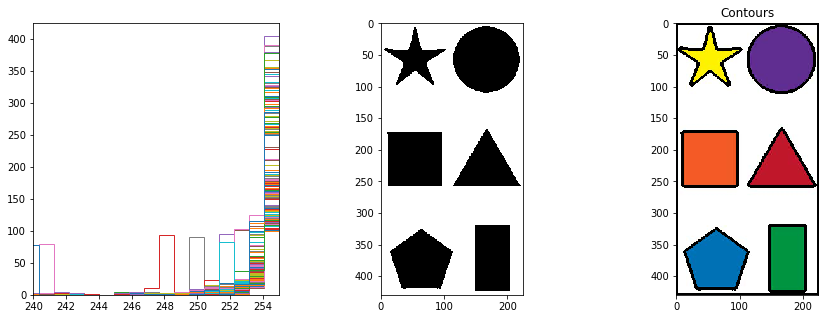

In [152]:
img = cv2.imread("images/shape.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_copy = img.copy()
img_contours = get_all_contours(img)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ref_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

vals = np.array(ref_gray)
b, bins, patches = ax[0].hist(vals, 255, histtype='step')
ax[0].set_xlim([240,255])

ref_gray = cv2.bilateralFilter(ref_gray, 11, 17, 17)
ret, thresh = cv2.threshold(ref_gray, 240, 255, 0)
ax[1].imshow(thresh)

contour_img = img.copy()
cv2.drawContours(contour_img, img_contours, -1,
                 color=(0,0,0), thickness=3)
ax[2].imshow(contour_img)
ax[2].set_title('Contours')
plt.show()

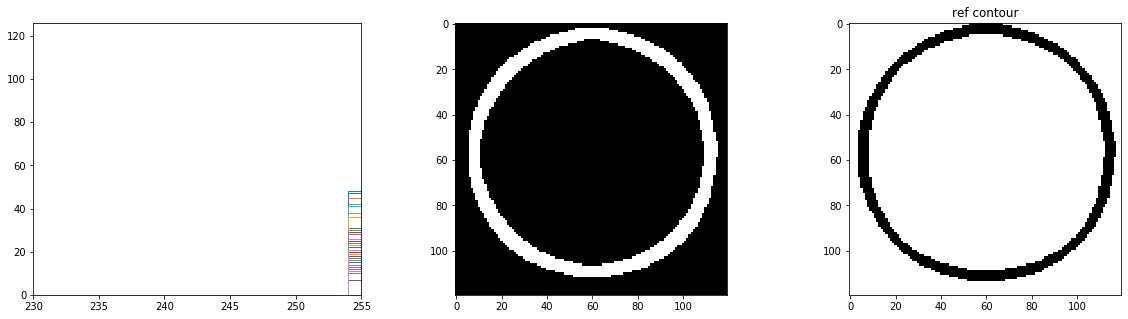

In [168]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# star_img = cv2.imread("images/star.jpg", cv2.IMREAD_UNCHANGED)
# trans_mask = star_img[:,:,3] == 0
# star_img[trans_mask] = [255, 255, 255, 255]
# star_img = cv2.cvtColor(star_img, cv2.COLOR_BGRA2RGB)

star_img = img[:120, -120:, :]

gray = cv2.cvtColor(star_img, cv2.COLOR_RGB2GRAY)
gray = cv2.bilateralFilter(gray, 11, 17, 17)
ret, gray = cv2.threshold(gray, 240, 255, 0)
edged = cv2.Canny(gray, 30, 200)
edged = cv2.dilate(edged, np.ones((5, 5), np.uint8), iterations = 1)

vals = np.array(edged)
b, bins, patches = ax[0].hist(vals, 255, histtype='step')

star_img_copy = star_img.copy(); star_img_copy[:] = (255, 255, 255)

edged = cv2.cvtColor(edged, cv2.COLOR_GRAY2RGB)
# ref_contour = get_ref_contour(edged, 240)
ref_contour = get_all_contours(edged, 240)[0]

contour_ref_img = cv2.drawContours(star_img_copy, ref_contour, -1,
                                   color=(0,0,0), thickness=3)
ax[1].imshow(edged)
ax[2].imshow(contour_ref_img)
ax[2].set_title("ref contour")
ax[0].set_xlim([230,255])
plt.show()

Contour 0 matchs in 0.132576
Contour 1 matchs in 0.009460
Contour 2 matchs in 0.125888
Contour 3 matchs in 0.024790
Contour 4 matchs in 0.100119
Contour 5 matchs in 0.206129
Contour 6 matchs in 0.000078


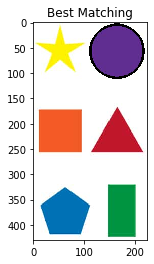

In [169]:
min_dist = None
for i, contour in enumerate(img_contours):
    ret = cv2.matchShapes(ref_contour, contour, 3, 0.0)
    print("Contour %d matchs in %f" % (i, ret))
    if min_dist is None or ret < min_dist:
        min_dist = ret
    closest_contour = contour

img_o = cv2.drawContours(img_copy, [closest_contour], -1, 
                 color=(0,0,0), thickness=3)
m_imshow(title='Best Matching', img=img_o)

* convex shapes: hình kín

## Phân loại shape bằng k-Means

* k-Means là một thuật toán phân cụm (clustering)
* Cách hoạt động: chia cụm -> xếp cụm -> tính lại cụm
* Có thể dùng k-Means để tìm các hình giống nhau
* solidity factor: tỉ lệ diện tích vùng trên diện tích convex hull (bao lồi)

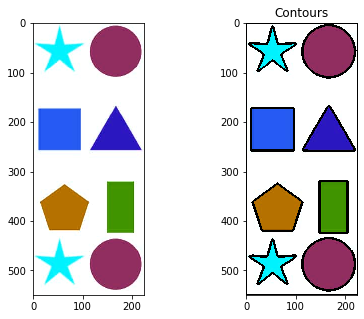

In [176]:
# Input image containing all the shapes
img = cv2.imread("images/shape.jpg")
img = np.concatenate((img, img[:120, :, :]), axis=0)
img_orig = np.copy(img)
input_contours = get_all_contours(img)

contour_img = img.copy()
cv2.drawContours(contour_img, input_contours, -1,
                 color=(0,0,0), thickness=3)

fig, ax = plt.subplots(1, 2, figsize=(7, 5))
ax[0].imshow(img)
ax[1].imshow(contour_img)
ax[1].set_title('Contours')
plt.show()

In [182]:
solidity_values = []

# Compute solidity factors of all the contours
for contour in input_contours:
    area_contour = cv2.contourArea(contour)
    convex_hull = cv2.convexHull(contour)
    area_hull = cv2.contourArea(convex_hull)
    solidity = float(area_contour)/area_hull
    solidity_values.append(solidity)

# Clustering using KMeans
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
flags = cv2.KMEANS_RANDOM_CENTERS
solidity_values = np.array(solidity_values).reshape((len(solidity_values),1)).astype('float32')
compactness, labels, centers = cv2.kmeans(solidity_values, 6, None, criteria, 10, flags)
closest_class = np.argmin(centers)

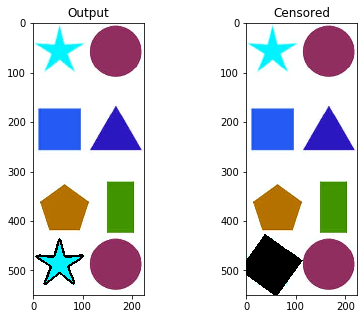

In [184]:
output_contours = []
fig, ax = plt.subplots(1, 2, figsize=(7, 5))

for i in solidity_values[labels==closest_class]:
    index = np.where(solidity_values==i)[0][0]
    output_contours.append(input_contours[index])
    cv2.drawContours(img, output_contours, -1, (0,0,0), 3)

ax[0].imshow(img)
ax[0].set_title('Output')

# Censoring
for contour in output_contours:
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    box = np.int0(box)

cv2.drawContours(img_orig, [box], 0, (0,0,0), -1)
ax[1].imshow(img_orig)
ax[1].set_title('Censored')
plt.show()

# Image segmentation

* Là quá trình phân tách ảnh thành các vùng nhỏ hơn.

## GrabCut

* Cách hoạt động:
    1. Xác định khu vực của vật thể cần tách vùng.
    2. Tính phân phối màu sắc giữa vật thể và nền bằng Gaussian mixture model. 
    3. Xây dựng Markov random field theo pixel labels ưu tiên các vùng cạnh nhau có chung label và chạy graph cut để tính giá trị mỗi vùng.
    4. Lặp bước 3 tới khi hội tụ.

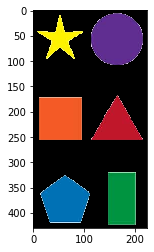

In [56]:
img = m_imread("images/shape.jpg")
mask = np.zeros(img.shape[:2], np.uint8)

bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)

rect = (2,2,630,930)
cv2.grabCut(img, mask, rect, bgdModel, 
            fgdModel, 5, cv2.GC_INIT_WITH_RECT)

mask2 = np.where((mask==2)|(mask==0), 0,1).astype('uint8')
img = img*mask2[:,:, np.newaxis]

m_imshow(img)

## Watershed algorithm

* Xét ảnh như bản đồ địa lý với độ cao thấp phụ thuộc vào độ sáng.
* Dựa vào các vùng có độ cao lớn để chia ảnh thành các vùng.
    * <img src="http://www.cmm.mines-paristech.fr/~beucher/lpe1.gif">


https://medium.com/@dhairya.vayada/intuitive-image-processing-watershed-segmentation-50a66ed2352e \
http://www.cmm.mines-paristech.fr/~beucher/wtshed.html

In [25]:
img = cv2.imread('images/coins.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

In [26]:
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

In [27]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0

In [28]:
markers = cv2.watershed(img,markers)
img[markers == -1] = [255,0,0]

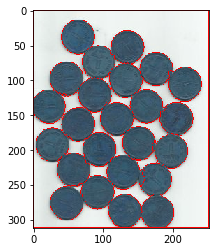

In [29]:
m_imshow(img)